Questions:
- Which brewery produces the strongest beers by abv ?
- If you had to pick 3 beers to recommend to someone, how would you approach the problem ?
- What are the factors that impacts the quality of beer the most ?
- I enjoy a beer which aroma and appearance matches the beer style. What beer should I buy ?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from category_encoders import TargetEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings("ignore")

In [2]:
# load the beer review dataset
beer_review = pd.read_csv("beer_reviews.csv")
beer_review.head()

,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
0,10325,Vecchio Birraio,1234817823,1.5,2.0,2.5,stcules,Hefeweizen,1.5,1.5,Sausa Weizen,5.0,47986
1,10325,Vecchio Birraio,1235915097,3.0,2.5,3.0,stcules,English Strong Ale,3.0,3.0,Red Moon,6.2,48213
2,10325,Vecchio Birraio,1235916604,3.0,2.5,3.0,stcules,Foreign / Export Stout,3.0,3.0,Black Horse Black Beer,6.5,48215
3,10325,Vecchio Birraio,1234725145,3.0,3.0,3.5,stcules,German Pilsener,2.5,3.0,Sausa Pils,5.0,47969
4,1075,Caldera Brewing Company,1293735206,4.0,4.5,4.0,johnmichaelsen,American Double / Imperial IPA,4.0,4.5,Cauldron DIPA,7.7,64883


In [3]:
# measure beer review dataset memory usage
beer_review.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1586614 entries, 0 to 1586613
Data columns (total 13 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   brewery_id          1586614 non-null  int64  
 1   brewery_name        1586599 non-null  object 
 2   review_time         1586614 non-null  int64  
 3   review_overall      1586614 non-null  float64
 4   review_aroma        1586614 non-null  float64
 5   review_appearance   1586614 non-null  float64
 6   review_profilename  1586266 non-null  object 
 7   beer_style          1586614 non-null  object 
 8   review_palate       1586614 non-null  float64
 9   review_taste        1586614 non-null  float64
 10  beer_name           1586614 non-null  object 
 11  beer_abv            1518829 non-null  float64
 12  beer_beerid         1586614 non-null  int64  
dtypes: float64(6), int64(3), object(4)
memory usage: 515.6 MB


In [4]:
# convert object columns to category dtype
for col in beer_review.select_dtypes(include="object").columns:
    beer_review[col] = beer_review[col].astype("category")

# beer_id, brewery_id are repitative, so it can be converted into category
beer_review["beer_beerid"] = beer_review["beer_beerid"].astype("category")
beer_review["brewery_id"] = beer_review["brewery_id"].astype("category")

# downcast numeric columns
for col in beer_review.select_dtypes(include=["number"]).columns:
    if pd.api.types.is_integer_dtype(beer_review[col]):
        beer_review[col] = pd.to_numeric(beer_review[col], downcast="integer")
    
    elif pd.api.types.is_float_dtype(beer_review[col]):
        beer_review[col] = pd.to_numeric(beer_review[col], downcast="float")



# convert review_time to datetime dtype
beer_review["review_time"] = pd.to_datetime(beer_review["review_time"], unit="s")

In [5]:
# check memory usage after optimization
beer_review.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1586614 entries, 0 to 1586613
Data columns (total 13 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   brewery_id          1586614 non-null  category      
 1   brewery_name        1586599 non-null  category      
 2   review_time         1586614 non-null  datetime64[ns]
 3   review_overall      1586614 non-null  float32       
 4   review_aroma        1586614 non-null  float32       
 5   review_appearance   1586614 non-null  float32       
 6   review_profilename  1586266 non-null  category      
 7   beer_style          1586614 non-null  category      
 8   review_palate       1586614 non-null  float32       
 9   review_taste        1586614 non-null  float32       
 10  beer_name           1586614 non-null  category      
 11  beer_abv            1518829 non-null  float32       
 12  beer_beerid         1586614 non-null  category      
dtypes: category(

In [6]:
# check for missing values
beer_review.isna().sum()

brewery_id                0
brewery_name             15
review_time               0
review_overall            0
review_aroma              0
review_appearance         0
review_profilename      348
beer_style                0
review_palate             0
review_taste              0
beer_name                 0
beer_abv              67785
beer_beerid               0
dtype: int64

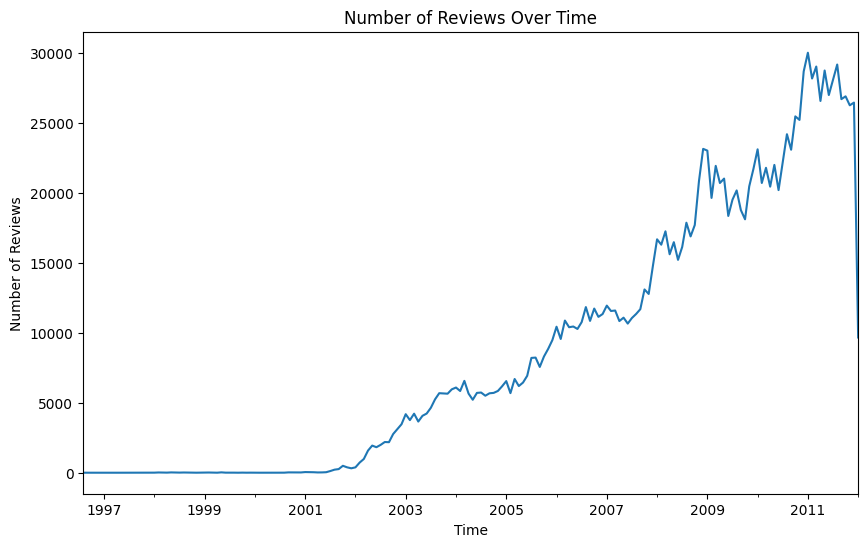

In [7]:
# plot number of reviews over time

plt.figure(figsize=(10,6))
beer_review.set_index("review_time").resample("M").size().plot()
plt.title("Number of Reviews Over Time")
plt.xlabel("Time")
plt.ylabel("Number of Reviews")
plt.show()

Main reviews have been collected beetween 2003 and 2011. 

### 1. Which brewery produces the strongest beers by abv ?

In [8]:
brewery_comp = (beer_review
                .dropna(subset=["brewery_name", "beer_abv"])
                .groupby("brewery_name")["beer_abv"]
                .agg(["mean", "max", "count"])
                .sort_values(ascending=False, by=["max", "mean"])
                .reset_index()
                .head(5)
)

brewery_comp

,brewery_name,mean,max,count
0,Schorschbräu,19.228823,57.700001,34
1,BrewDog,9.905217,41.000000,4033
2,De Struise Brouwers,10.762804,39.000000,3866
3,Hair of the Dog Brewing Company / Brewery and ...,9.407350,29.000000,3769
4,Boston Beer Company (Samuel Adams),6.414817,27.000000,38812


**Schorschbräu** produces the strongest beer of *ABV 57.7%*, but only has 34 beers in the dataset. 

Also, **BrewDog** and **De Struise Brouwers** produce very strong beers respectively 41% and 39% ABV and they have more reviews and beers.

### If you had to pick 3 beers to recommend to someone, how would you approach the problem ?


Usually "best" means a combination of high review scores, popularity, and diversity of styles. To find that filter out not popular beers, calculate average of overall rating, and sort by average rating.

In [9]:
# filter beers with at least 100 reviews to avoid outliers
beer_counts = beer_review[["beer_name", "beer_style"]].value_counts().reset_index()
beer_counts.columns = ["beer_name", "beer_style", "count"]
popular_beers = beer_counts[beer_counts["count"] >= 100][["beer_name", "beer_style"]]

# calculate average overall rating and review count per beer
beer_scores = (
    beer_review
    .merge(popular_beers, on=["beer_name", "beer_style"], how="inner")
    .groupby(["beer_name", "beer_style"])["review_overall"]
    .agg(['mean', 'count'])
    .reset_index()
    .rename(columns={'mean': 'avg_rating', 'count': 'review_count'})
)

# sort by rating
top_beers = (
    beer_scores
    .sort_values("avg_rating", ascending=False)
    .drop_duplicates("beer_style")
)

top_beers.head(5)

,beer_name,beer_style,avg_rating,review_count
1297201,Citra DIPA,American Double / Imperial IPA,4.630952,252
1118802,Cantillon Blåbær Lambik,Lambic - Fruit,4.628205,156
1565012,Deviation - Bottleworks 9th Anniversary,American Wild Ale,4.620536,112
5393006,Trappist Westvleteren 12,Quadrupel (Quad),4.617925,1272
2011267,Founders CBS Imperial Stout,American Double / Imperial Stout,4.591052,637


**Citra DIPA, Cantillon Blåbær Lambik, Deviation - Bottleworks 9th Anniversary** beers have decent number of reviews and their overall average score is higher than 4.6

### What are the factors that impacts the quality of beer the most ?

To find the impact factors of qaulity I will check *review aroma, appearance, palate, taste, abv* columns correlation to the **overall review**. 

In [10]:
cols = ["review_overall", "review_aroma", "review_appearance", "review_palate", "review_taste", "beer_abv"]
corr = beer_review[cols].dropna().corr()

# correlation with overall review
corr_with_overall = corr["review_overall"].sort_values(ascending=False)
corr_with_overall

review_overall       1.000000
review_taste         0.787193
review_palate        0.699040
review_aroma         0.612826
review_appearance    0.498576
beer_abv             0.138512
Name: review_overall, dtype: float64

**review_taste** with **0.79** has the strongest impact on overall beer quality. It means that better the taste, the higher the overall review.

**review_palate - 0.70** and **review_aroma - 0.62**  plays significantly affects how people rate beer.

**review_appearance - 0.50**, appearance matters less than taste, palate, and aroma.

At least **beer_abv - 0.14**, alcohol content has a weak positive correlation with quality.

*Overall, taste, palate - mouthfeel, and aroma are the most important factors for beer quality.*

##### Build simple classification model to find future importance. Target is overall review

In [ ]:
cat_cols = ["brewery_name", "beer_style", "beer_name"]
num_cols = ["beer_abv", "review_aroma", "review_appearance", "review_palate", "review_taste"]

df = beer_review[cat_cols + num_cols + ["review_overall"]].dropna().copy(deep=True)

# covert overall review to multi-class classification problem
target_mapping = {score: idx for idx, score in enumerate([0.0, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0])}
df["review_overall"] = df["review_overall"].map(target_mapping)


# convert categorical columns to numeric using Target Encoding because of high cardinality of categorical columns
for col in cat_cols:
    # print(f"{col}: {df[col].nunique()} unique values")
    encoder = TargetEncoder() 
    df[col] = encoder.fit_transform(df[col], df["review_overall"])

# split data into train and test sets
X = df.drop("review_overall", axis=1)   
y = df["review_overall"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# build a simple logistic regression model
model = LogisticRegression(max_iter=500, 
                           penalty="elasticnet", 
                           solver="saga", 
                           l1_ratio=0.5,
)

model.fit(X_train, y_train)

acccuracy = model.score(X_test, y_test)

print(f"Model accuracy: {acccuracy:.2f}")


In [ ]:
feature_names = X_train.columns

# absolute mean coefficients across classes
importance = np.mean(np.abs(model.coef_), axis=0)

importances_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importance
}).sort_values('importance', ascending=False)

importances_df

### I enjoy a beer which aroma and appearance matches the beer style.  What beer should I buy ?

To recommend beers where aroma and appearance best match the beer style, I calculate average aroma and appearance scores for each beer style. Then find beers whithin each style that have aroma and appearance scores close to the style averaga. 

In [11]:
# average aroma and appearance for each style
style_avgs = (
    beer_review
    .groupby("beer_style")[["review_aroma", "review_appearance"]]
    .mean()
    .reset_index()
    .rename(columns={"review_aroma": "avg_aroma", "review_appearance": "avg_appearance"})
)

# merge style averages
beer_with_style = beer_review.merge(style_avgs, on="beer_style", how="left")

# find beers where aroma and appearance are above style average
matched_beers = beer_with_style[
    (beer_with_style["review_aroma"] >= beer_with_style["avg_aroma"]) &
    (beer_with_style["review_appearance"] >= beer_with_style["avg_appearance"])
]

# top beers by overall rating
recommendations = (
    matched_beers
    .groupby(["beer_name", "beer_style"])
    .agg({"review_overall": "mean", "review_aroma": "mean", "review_appearance": "mean"})
    .reset_index()
    .sort_values("review_overall", ascending=False)
    .drop_duplicates("beer_style")
)

recommendations.head()

,beer_name,beer_style,review_overall,review_aroma,review_appearance
5911421,ÜberFest Pilsner,German Pilsener,5.0,4.0,4.5
1162,"""Best Of Both Worlds"" Stout",American Stout,5.0,4.5,4.5
321064,Aries American Wheat,American Pale Wheat Ale,5.0,4.0,5.0
323130,Armadillo Amber,American Amber / Red Ale,5.0,4.5,4.0
4000478,Patchway Pale Ale,American Pale Ale (APA),5.0,4.5,4.0


**ÜberFest Pilsner, "Best Of Both Worlds" Stout, Aries American Wheat** beers are top 3 for recommend people who prefer aroma and appearance matches to beer style. 